# HH binary inputs model
Code to prototype the Hodgkin-Huxley model with excitatory and inhibitory inputs


In [1]:
import gc
from neuron import h
from neuron.units import mV, ms
import numpy as np
h.load_file('stdrun.hoc')

import matplotlib.pyplot as plt

In [2]:
class HH:
    def __init__(self):
        # set up simulation
        self.axon = h.Section(name='axon')
        self.axon.insert(h.hh)
        
        # store stimuli
        self.syns = [] # synapses
        self.syn_currents = [] # synapse recordings
        self.stims = [] # stimuli
        self.all_stim_times = [] # stim times recording
        self.netcons = [] # net connections
        
        # setup simulation recording
        self._t = h.Vector().record(h._ref_t, sec=self.axon)
        self._v = h.Vector().record(self.axon(0.5)._ref_v)
        self._m = h.Vector().record(self.axon(0.5).hh._ref_m)
        self._n = h.Vector().record(self.axon(0.5).hh._ref_n)
        self._h = h.Vector().record(self.axon(0.5).hh._ref_h)
        self.spike_times = h.Vector()
        self.nc_self = h.NetCon(self.axon(0.5)._ref_v, None, sec=self.axon)
        self.nc_self.record(self.spike_times)
    

    def add_stimulus(self, stim_interval, reversal_potential, weight, tau):
        # add synapse
        syn = h.ExpSyn(self.axon(0))
        syn.tau = tau
        syn.e = reversal_potential * mV
        syn_current = h.Vector().record(syn._ref_i)
        
        self.syns.append(syn)
        self.syn_currents.append(syn_current)

        # add stimulus
        stim = h.NetStim()
        stim.number = 9999999
        stim.interval = stim_interval * ms
        stim.noise = True
        stim.start = 0 * ms
        stim_times = h.Vector()
        
        self.stims.append(stim)
        self.all_stim_times.append(stim_times)

        # connect stimulus #1 (excitatory) to synapse
        nc = h.NetCon(stim, syn)
        nc.delay = 0 * ms
        nc.weight[0] = weight
        nc.record(stim_times)
        
        self.netcons.append(nc)
        
    def run_simulation(self, sim_length):
        # run simulation
        h.finitialize(-65 * mV)
        h.continuerun(sim_length * ms)

In [64]:
_df = np.array((list(exp1._t), list(exp1._v), list(exp1._m), list(exp1._n), list(exp1._h)))
print(_df.shape)
sampled_inds = np.random.randint(_df.shape[1], size=10)
_df[:,sampled_inds].shape

(5, 40001)


(5, 10)

In [69]:
_df[4,0]

0.5961207535084603

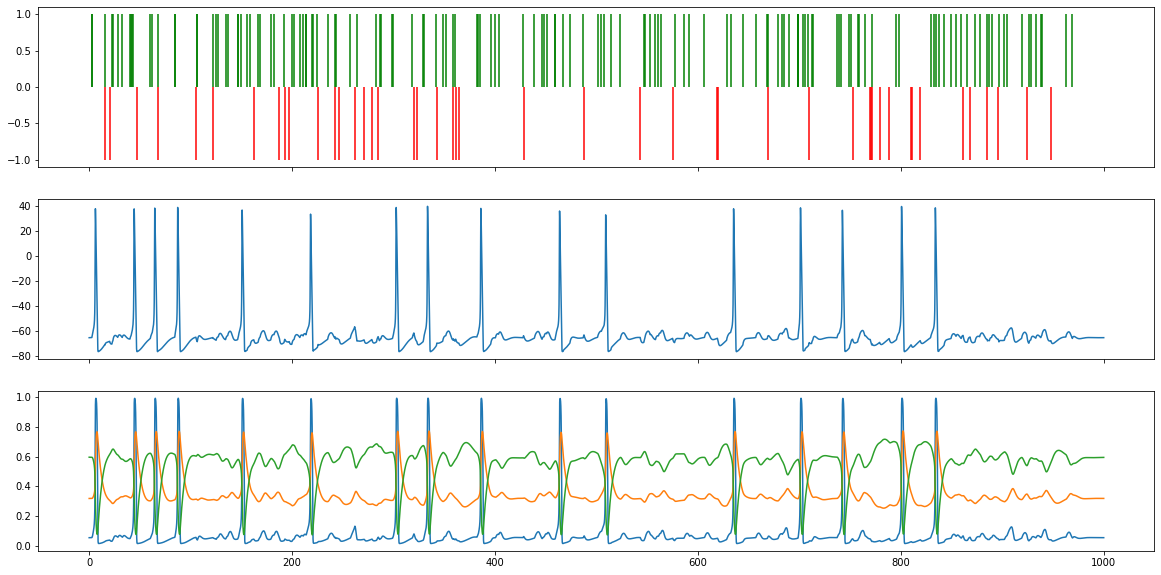

In [63]:
exp1 = HH()
exp1.add_stimulus(stim_interval = 7, reversal_potential = 0, weight = 0.1, tau=2 * ms)  #AMPA
exp1.add_stimulus(stim_interval = 20, reversal_potential = -80, weight = .5, tau=6 * ms) #GABAA
exp1.run_simulation(1000)

fig, axes = plt.subplots(3,1,figsize=(20,10), sharex = True)

colors = ['green','red']
for i, stim_times in enumerate(exp1.all_stim_times):
    
    axes[0].vlines(list(stim_times), 0-i, 1-i, color = colors[i])

axes[1].plot(exp1._t, exp1._v)

axes[2].plot(exp1._t, exp1._m)
axes[2].plot(exp1._t, exp1._n)
axes[2].plot(exp1._t, exp1._h)
plt.show()

In [4]:
len(exp1.spike_times)

44

## look at output spiking rates as a function of stimuli parameters

In [5]:
e_Hz_sweep = range(100,1001,25)
i_Hz_sweep = range(0,501,25)
model_length = 10000

# print progress bar
print('_'*len(e_Hz_sweep))

spike_rates = np.zeros((len(e_Hz_sweep), len(i_Hz_sweep)))
for e, e_hz in enumerate(e_Hz_sweep):
    e_interval = 1000/e_hz
    for i, i_hz in enumerate(i_Hz_sweep):
        exp1 = HH()
        exp1.add_stimulus(stim_interval = e_interval, reversal_potential = 0, weight = 0.1, tau=2 * ms)  #AMPA
        if i_hz != 0:
            i_interval = 1000/i_hz
            exp1.add_stimulus(stim_interval = i_interval, reversal_potential = -80, weight = .5, tau=6 * ms) #GABAA
        exp1.run_simulation(model_length)
        
        spike_rate = (len(exp1.spike_times) / model_length) * 1000
        #print(e_interval, '\t', i_interval, '\t', spike_rate)
        
        spike_rates[e,i] = spike_rate
    print('=', end='')

_____________________________________

In [2]:
def hz_2_spikerate(hz):
    return 1000/hz

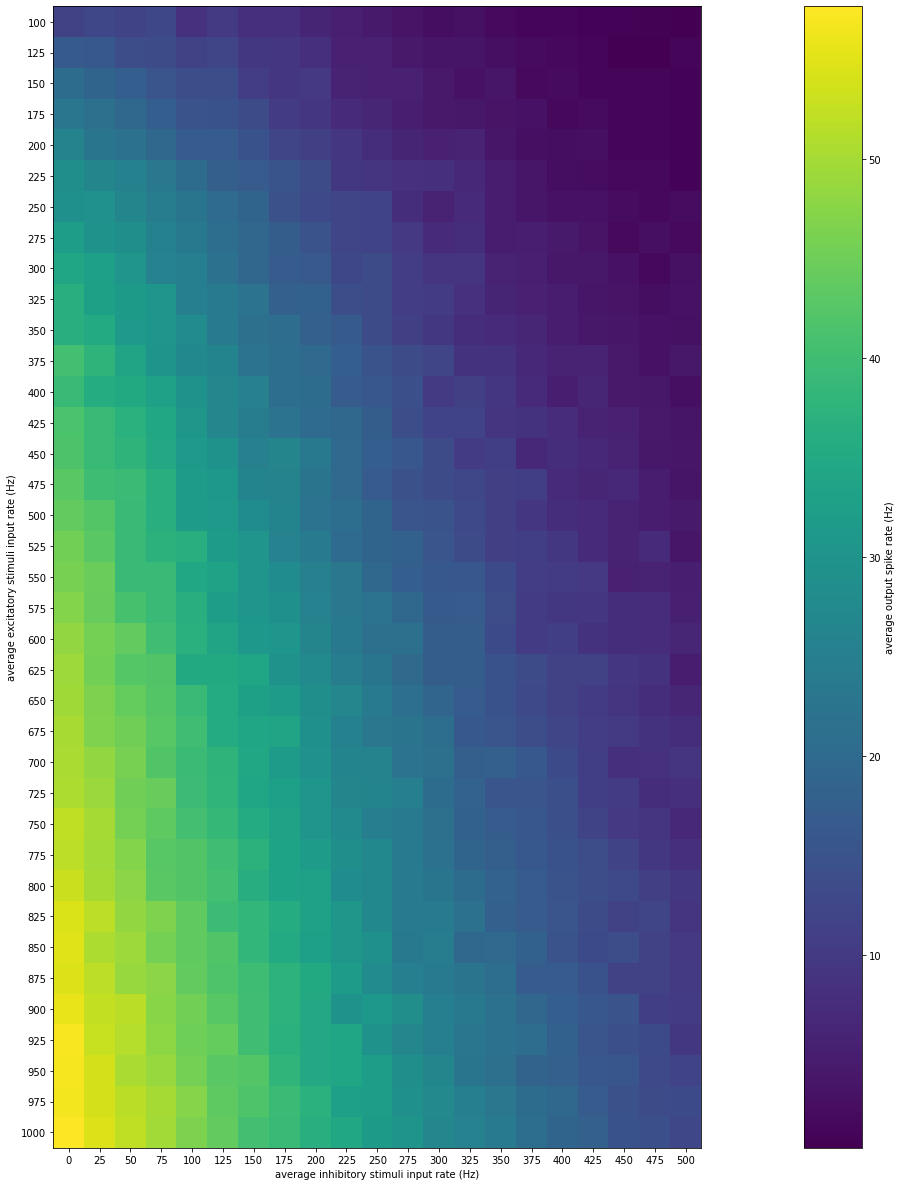

In [6]:
plt.figure(figsize=(len(e_Hz_sweep),len(i_Hz_sweep)))
plt.imshow(spike_rates)
plt.xlabel('average inhibitory stimuli input rate (Hz)')
plt.yticks(range(len(e_Hz_sweep)), e_Hz_sweep)
plt.xticks(range(len(i_Hz_sweep)), i_Hz_sweep)
plt.ylabel('average excitatory stimuli input rate (Hz)')
cbar = plt.colorbar()
cbar.set_label('average output spike rate (Hz)')
plt.show()

In [7]:
hz_2_spikerate(80)

12.5

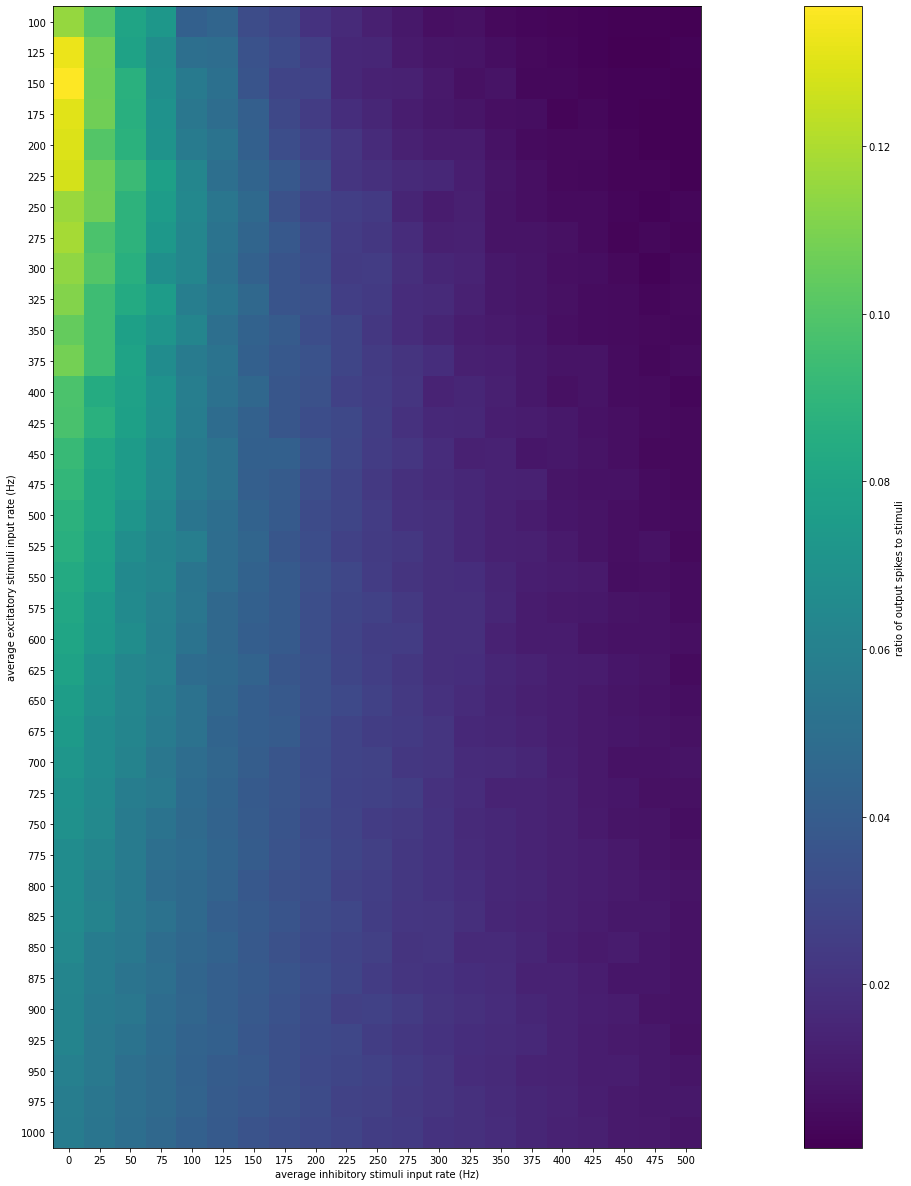

In [7]:
spike_stimuli_ratios = np.zeros((len(e_Hz_sweep), len(i_Hz_sweep)))
for e, e_hz in enumerate(e_Hz_sweep):
    for i, i_hz in enumerate(i_Hz_sweep):
        spike_stimuli_ratios[e,i] = spike_rates[e,i]/(e_hz + i_hz) 
        
plt.figure(figsize=(len(e_Hz_sweep),len(i_Hz_sweep)))
plt.imshow(spike_stimuli_ratios)
plt.xlabel('average inhibitory stimuli input rate (Hz)')
plt.yticks(range(len(e_Hz_sweep)), e_Hz_sweep)
plt.xticks(range(len(i_Hz_sweep)), i_Hz_sweep)
plt.ylabel('average excitatory stimuli input rate (Hz)')
cbar = plt.colorbar()
cbar.set_label('ratio of output spikes to stimuli')
plt.show()